In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# URL Download
import csv
import io
import urllib.request
import requests

# Read in data

In [320]:
df_theft = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

In [321]:
df_theft.head()

,Unnamed: 0,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,datetime_theft_mean,BZR,PGR,Bezirk
0,0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,7100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0,2022-02-26 14:00:00,71001,710,7
1,1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,2100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0,2022-02-28 16:00:00,21001,210,2
2,2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,8300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0,2022-02-28 20:00:00,83009,830,8
3,3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,4400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0,2022-02-28 08:00:00,44007,440,4
4,4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,9100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0,2022-02-25 11:00:00,91003,910,9


# Group theft data by Bezirk and date_reported

In [322]:
# Group dataframe by date and LOR
df_theft = df_theft.pivot_table(index = "date_reported", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft.fillna(value = 0, inplace=True)

In [323]:
# create "total" column which sums up data for each day
df_theft["total"] = df_theft.sum(axis=1)


df_theft.shape

(424, 13)

In [326]:
df_theft = df_theft[["total"]]

In [283]:
# as the last step we rename the date column to match the name in df_feat
df_theft = df_theft.rename(columns={"date_reported": "date"})

In [346]:
df_theft.index.min(), df_theft.index.max()

('2021-01-01', '2022-02-28')

In [345]:
pd.date_range(start = df_theft.index.min(), end = df_theft.index.max()).difference(df_theft.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [343]:
df_theft.index.min()

'2021-01-01'

In [327]:
def calculate_rolling_average(df, window_size):
    fill_value = df["total"][-window_size:].mean()
    df["total_moving_average"] = df["total"].rolling(window = window_size, center = False).mean().fillna(fill_value)
    return df

# Calculate Rolling Average

In [328]:
df_theft = calculate_rolling_average(df_theft, 5)

In [329]:
df_theft.head()

Bezirk,total,total_moving_average
date_reported,,
2021-01-01,4.0,39.0
2021-01-02,7.0,39.0
2021-01-03,3.0,39.0
2021-01-04,21.0,39.0
2021-01-05,31.0,13.2


# Train-test-split

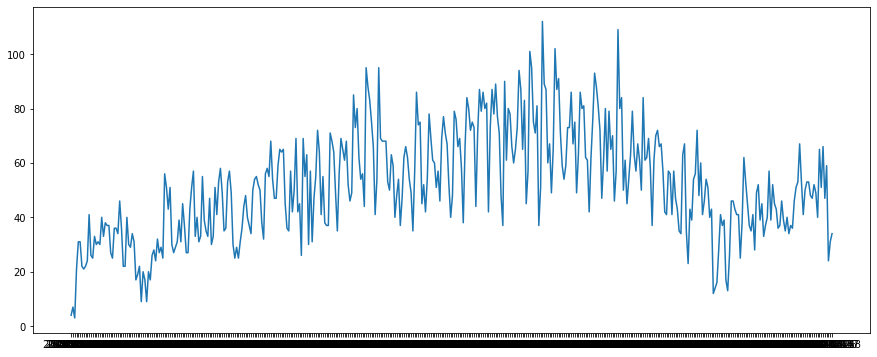

In [330]:
plt.figure(figsize = (15, 6))
plt.plot(df_theft["total"]);

In [331]:
int(len(df_theft) * 0.8)

339

In [332]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset.iloc[i: i + window_size])
    y.append(dataset["total"][i + window_size + future_horizon -1 : i + window_size  + future_horizon, ])

  return np.array(X), np.array(y)

In [333]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_theft.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_theft.iloc[339:, :])

In [334]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 2), (307, 1), (53, 31, 2), (53, 1))

In [335]:
es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

In [336]:
def create_opt_model(): 
    """
    Creates the finetuned model selected in B_Theft_Modelling
    Outputs models, that needs to be compiled and fit"""
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
    model.add(Dropout(0.2))
    # second LSTM layer
    model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))
    return model

# Baseline model (last observation)

In [347]:
X_train.shape

(307, 31, 2)

In [348]:
y_pred_base = X_test[:,-1,0]
y_pred_base.shape

(53,)

In [349]:
y_test.shape

(53, 1)

In [350]:
mean_absolute_percentage_error(y_test, y_pred_base)*100

21.743157887296032

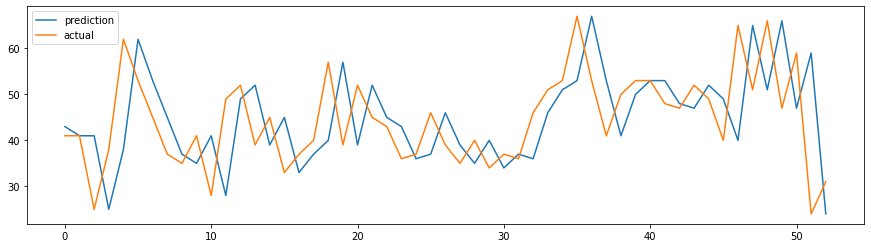

In [351]:
plt.figure(figsize= (15, 4))
plt.plot(y_pred_base, label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();

# Feed into model

In [337]:
opt_model = create_opt_model()
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 1, 
                  callbacks = [es], 
                  validation_split = 0.2)

Epoch 1/300
31/31 [==============================] - 3s 35ms/step - loss: 3188.1404 - mean_absolute_percentage_error: 96.4455 - val_loss: 3931.6501 - val_mean_absolute_percentage_error: 94.1249
Epoch 2/300
31/31 [==============================] - 1s 18ms/step - loss: 2814.0215 - mean_absolute_percentage_error: 88.6416 - val_loss: 3567.3049 - val_mean_absolute_percentage_error: 89.1173
Epoch 3/300
31/31 [==============================] - 1s 18ms/step - loss: 2586.3032 - mean_absolute_percentage_error: 83.6599 - val_loss: 3381.0811 - val_mean_absolute_percentage_error: 86.4528
Epoch 4/300
31/31 [==============================] - 1s 19ms/step - loss: 2473.6438 - mean_absolute_percentage_error: 81.0495 - val_loss: 3257.0750 - val_mean_absolute_percentage_error: 84.6347
Epoch 5/300
31/31 [==============================] - 1s 18ms/step - loss: 2390.2744 - mean_absolute_percentage_error: 78.9714 - val_loss: 3146.9636 - val_mean_absolute_percentage_error: 82.9893
Epoch 6/300
31/31 [===========

31/31 [==============================] - 1s 18ms/step - loss: 301.1749 - mean_absolute_percentage_error: 25.9344 - val_loss: 309.9669 - val_mean_absolute_percentage_error: 20.4984
Epoch 86/300
31/31 [==============================] - 1s 18ms/step - loss: 294.4617 - mean_absolute_percentage_error: 25.7607 - val_loss: 304.4167 - val_mean_absolute_percentage_error: 20.3180
Epoch 87/300
31/31 [==============================] - 1s 18ms/step - loss: 281.1695 - mean_absolute_percentage_error: 24.9560 - val_loss: 298.5236 - val_mean_absolute_percentage_error: 20.1197
Epoch 88/300
31/31 [==============================] - 1s 19ms/step - loss: 284.9232 - mean_absolute_percentage_error: 25.7355 - val_loss: 293.2954 - val_mean_absolute_percentage_error: 19.9377
Epoch 89/300
31/31 [==============================] - 1s 18ms/step - loss: 266.8873 - mean_absolute_percentage_error: 25.0274 - val_loss: 288.4636 - val_mean_absolute_percentage_error: 19.7646
Epoch 90/300
31/31 [============================

In [338]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 82.5824 - mean_absolute_percentage_error: 16.5710


[82.58243560791016, 16.57095718383789]

In [340]:
opt_model.predict(X_test).shape

(53, 1)

In [341]:
y_test.shape

(53, 1)

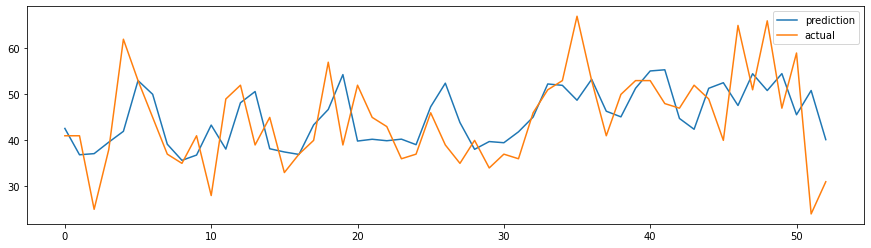

In [339]:
plt.figure(figsize= (15, 4))
plt.plot(opt_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();